In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
# from tensorflow import keras
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-06-16 19:55:49.406865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 19:55:50.060552: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bigdata_user5/Desktop/envs/nobo/lib/python3.7/site-packages/cv2/../../lib64:/home/bigdata_user5/Desktop/envs/nobo/lib/
2023-06-16 19:55:50.060622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home

In [2]:
# import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.11.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


2023-06-16 19:55:52.425697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 19:55:53.011118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [3]:
# from keras_applications.EfficientNetV2B2 import , preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D, Dense, Dropout, Input
# from tensorflow.keras.models import Model
# from keras.utils import plot_model

# create ResNet50 and Xception models
efficientnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# create input tensor
input_tensor1 = Input(shape=(224, 224, 3))
# input_tensor2 = Input(shape=(224, 224, 3))

# preprocess input for ResNet50 and XceptionNet
# efficientnet_processed = tf.keras.applications.efficientnet_v2.preprocess_input(input_tensor1)
# xception_processed = xception_preprocess_input(input_tensor1)

# extract features from both models
efficientnet_features = efficientnet_model(input_tensor1)
xception_features = xception_model(input_tensor1)

# concatenate features
concatenated = Concatenate()([efficientnet_features, xception_features])

# add global average pooling layer
pooled = GlobalAveragePooling2D()(concatenated)

# add fully connected layers for classification
fc1 = Dense(512, activation='relu')(pooled)
dropout = Dropout(0.5)(fc1)
fc2 = Dense(190, activation='softmax')(dropout)

# create modelmiddle_finger/Proposed_MFKR_Model copy_GRADCAM.ipynb
model = Model(inputs=input_tensor1, outputs=fc2)

e_features = Model(inputs=input_tensor1, outputs=[efficientnet_features,fc2])
x_features = Model(inputs=input_tensor1, outputs=[xception_features,fc2])
c_features = Model(inputs=input_tensor1, outputs=[concatenated,fc2])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# plot model architecture
# plot_model(model, show_shapes=True, to_file='model.png')
# model.summary()

2023-06-16 19:55:54.785249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [4]:
from tensorflow.keras.models import load_model

model = load_model('checkpoint/MFKR_Model_Aug_pre_50epochs.hdf5')

In [5]:
# from keras.models import Model
# import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName == "efficient":
            self.model=e_features
        elif self.layerName == "xception":
            self.model=x_features
        else:
            self.model = c_features
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        # import code
        # code.interact(local=locals())
        
        # gradModel = Model(
        #     inputs=self.model.inputs,
        #     outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        gradModel = self.model

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the losshistory1
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [7]:
# image_paths = ['/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject4/session2/middlefinger/set1/3D/P7.bmp', 
#                '/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject4/session2/middlefinger/set1/3D/P3.bmp',
#                '/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject4/session2/middlefinger/set1/3D/P1.bmp']

# processed_images = []

# for path in image_paths:
#     image = cv2.imread(path)
#     image = cv2.resize(image, (224, 224))
#     image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#     image = np.expand_dims(image, axis=0)
#     processed_images.append(image)

# processed_images = np.concatenate(processed_images, axis=0)

In [58]:
image = cv2.imread('/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject182/session2/middlefinger/set1/3D/P2.bmp')
image = cv2.resize(image, (224, 224))
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
# image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)


print(image.shape)
preds = model.predict(image)
i = np.argmax(preds[0])

(1, 224, 224, 3)
1/1 [==============================] - 0s 36ms/step


In [59]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name,model.get_layer(index = idx).output_shape,model.get_layer(index = idx).trainable)

input_3 [(None, 224, 224, 3)] True
tf.math.truediv (None, 224, 224, 3) True
tf.math.subtract (None, 224, 224, 3) True
efficientnetv2-b2 (None, 7, 7, 1408) True
xception (None, 7, 7, 2048) True
concatenate (None, 7, 7, 3456) True
global_average_pooling2d (None, 3456) True
dense (None, 512) True
dropout (None, 512) True
dense_1 (None, 190) True


In [60]:
for i in model.layers:
    print(str(i))

(224, 224) (1, 224, 224, 3)
uint8 float32
254 0.9215687
(224, 224) (224, 224, 3)
uint8 uint8
254 235


Text(0.5, 1.0, 'Overlay Heatmap')

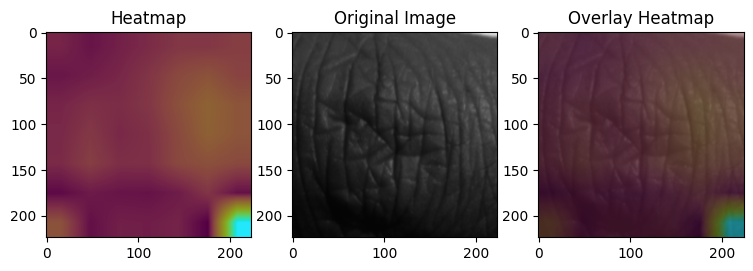

In [61]:
icam = GradCAM(model, i, 'concatenation')
heatmap = icam.compute_heatmap(image)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

image = np.array(image).astype("float")
image = image*255

image = np.mean(image, axis=-1).squeeze()
image = np.round(image).astype('uint8')
heatmap = np.array(heatmap).astype("uint8")

image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(9,9))

ax[0].imshow(heatmap)
ax[0].set_title('Heatmap')
ax[1].imshow(image)
ax[1].set_title('Original Image')
ax[2].imshow(output)
ax[2].set_title('Overlay Heatmap')

In [18]:
image = cv2.imread('/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject128/session2/middlefinger/set1/3D/P1.bmp')
image = cv2.resize(image, (224, 224))
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
# image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)


print(image.shape)
preds = model.predict(image)
i = np.argmax(preds[0])

for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name,model.get_layer(index = idx).output_shape,model.get_layer(index = idx).trainable)
  
for i in model.layers:
    print(str(i))


(1, 224, 224, 3)
1/1 [==============================] - 0s 39ms/step
input_3 [(None, 224, 224, 3)] True
tf.math.truediv (None, 224, 224, 3) True
tf.math.subtract (None, 224, 224, 3) True
efficientnetv2-b2 (None, 7, 7, 1408) True
xception (None, 7, 7, 2048) True
concatenate (None, 7, 7, 3456) True
global_average_pooling2d (None, 3456) True
dense (None, 512) True
dropout (None, 512) True
dense_1 (None, 190) True


(224, 224) (1, 224, 224, 3)
uint8 float32
254 0.29803923
(224, 224) (224, 224, 3)
uint8 uint8
254 76


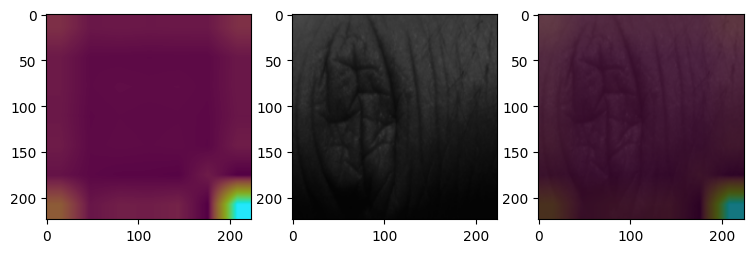

In [19]:
icam = GradCAM(model, i, 'efficient')
heatmap = icam.compute_heatmap(image)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

image = np.array(image).astype("float")
image = image*255

image = np.mean(image, axis=-1).squeeze()
image = np.round(image).astype('uint8')
heatmap = np.array(heatmap).astype("uint8")

image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(9,9))

ax[0].imshow(heatmap)
ax[0].set_title('Heatmap')
ax[1].imshow(image)
ax[1].set_title('Original Image')
ax[2].imshow(output)
ax[2].set_title('Overlay heatmap')

In [20]:
image = cv2.imread('/home/bigdata_user5/nobo/3Dfingerknuckle_with_Aug/3D_Finger_Knuckle_Database/segmented_data_down/subject128/session2/middlefinger/set1/3D/P1.bmp')
image = cv2.resize(image, (224, 224))
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
# image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)


print(image.shape)
preds = model.predict(image)
i = np.argmax(preds[0])

for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name,model.get_layer(index = idx).output_shape,model.get_layer(index = idx).trainable)
  
for i in model.layers:
    print(str(i))


(1, 224, 224, 3)
1/1 [==============================] - 0s 38ms/step
input_3 [(None, 224, 224, 3)] True
tf.math.truediv (None, 224, 224, 3) True
tf.math.subtract (None, 224, 224, 3) True
efficientnetv2-b2 (None, 7, 7, 1408) True
xception (None, 7, 7, 2048) True
concatenate (None, 7, 7, 3456) True
global_average_pooling2d (None, 3456) True
dense (None, 512) True
dropout (None, 512) True
dense_1 (None, 190) True


(224, 224) (1, 224, 224, 3)
uint8 float32
254 0.29803923
(224, 224) (224, 224, 3)
uint8 uint8
254 76


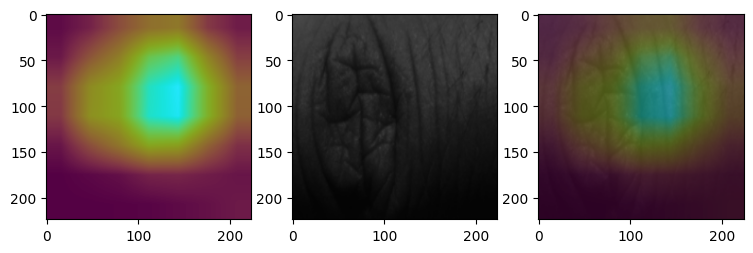

In [13]:
icam = GradCAM(model, i, 'xception')
heatmap = icam.compute_heatmap(image)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

image = np.array(image).astype("float")
image = image*255

image = np.mean(image, axis=-1).squeeze()
image = np.round(image).astype('uint8')
heatmap = np.array(heatmap).astype("uint8")

image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

print(heatmap.shape, image.shape)
print(heatmap.dtype,image.dtype)
print(heatmap.max(),image.max())

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(9,9))

ax[0].imshow(heatmap)
ax[0].set_title('Heatmap')
ax[1].imshow(image)
ax[1].set_title('Original Image')
ax[2].imshow(output)
ax[2].set_title('Overlay heatmap')